In [328]:
import casperfpga
import numpy as np
from matplotlib import pyplot as plt
import struct
import time
%matplotlib widget

In [329]:
def Scope(darray):
    try:
        plt.close('all')
    except:
        pass
    fig = plt.figure()
    subfig = fig.add_subplot(111)
    for d in darray:
        subfig.plot(d)
    subfig.set_title('Time Domain Data')
    subfig.set_xlabel('Samples')
    subfig.grid(True)

def CreateTestFilter(dac_fft_len, fft_points, bw=1):
    N = dac_fft_len//2
    fil = np.zeros(N)
    L = int(N*bw)
    passband = np.zeros(L)
    factor = dac_fft_len//fft_points/2
    for i in range(L):
        # we need to filter DC
        if i == 0:
            continue
        elif i%factor == 0:
            passband[i] = 1
    fil[:L] = passband
    return fil
    
    
def DacDataGen(channel_num, cfil, single_bin=0, scale=2**13):
    N = channel_num
    M = (N//2)-1
    fil = np.zeros(M+1)
    if single_bin == 0:
        fil = cfil
    else:
        fil[single_bin] = 1
    d_freq = np.zeros(N) + 1j*np.zeros(N)
    d_freq_half0 = np.exp(1j*np.random.uniform(0, 2*np.pi, size=M)) * fil[1:M+1]
    d_freq_half1 = np.conjugate(d_freq_half0)[::-1]
    d_freq[1:M+1] = d_freq_half0
    d_freq[-M:] = d_freq_half1
    d_time = np.fft.ifft(d_freq)
    d_time_int = np.round((d_time*scale))
    return d_time_int

def ADCSampling(data, adc_fs=500, dac_fs=1000):
    decimation_factor = int(dac_fs/adc_fs)
    tmp = data.reshape(-1, decimation_factor)
    return tmp[:,0]

def LPFilter(data, bw=0.5):
    l = int(len(data)/2)
    fil = np.zeros(l*2)
    passband_len = int(2*l*bw)
    passband = np.ones(passband_len)
    # we don't need DC
    passband[0] = 0
    fil[:passband_len] = passband
    tmp = fil[:l][::-1]
    fil[-l:] = tmp
    data = data * fil
    return data
    
def SpectraAnalyzer(data, fs=1000, show_bin=False):
    N = len(data)
    spec = np.fft.fft(data)
    spec_shift = np.fft.fftshift(spec)
    freq = np.fft.fftfreq(N, 1/fs)
    freq_shift = np.fft.fftshift(freq)
    try:
        plt.close('all')
    except:
        pass
    fig = plt.figure()
    subfig = fig.add_subplot(111)
    if show_bin == True:
        s = np.abs(spec_shift[-int(N/2):])
        subfig.plot(np.arange(len(s)),s)
        subfig.set_xlabel('Bins')
    else:
        subfig.plot(freq_shift[-int(N/2):], abs(spec_shift[-int(N/2):]))
        subfig.set_xlabel('MHz')
    subfig.set_title('Spectra Data')
    subfig.set_yscale('log')
    subfig.grid(True)
    return spec

def ToBytes(data):
    N = len(data)
    data = np.short(data)
    buf = struct.pack('>%dh'%N, *data)
    return buf

In [330]:
rfsoc=casperfpga.CasperFpga('192.168.88.109')

In [197]:
# config RFSoC2z2
rfsoc.upload_to_ram_and_program('rfsocdactut_2025-06-30_1113.fpg')
rfdc = rfsoc.adcs['rfdc']
# init rfdc
rfdc.init()

True

In [340]:
# init LMK and LMX
c = rfdc.show_clk_files()
# ref = 12.5MHz
# rfdc.progpll('lmk', c[0])
# ref = 250MHz
rfdc.progpll('lmk', c[1])
rfdc.progpll('lmx', c[3])
time.sleep(1)
rfdc.status()

ADC0: Enabled 1, State 0, PLL -1580255468
ADC1: Enabled 0
ADC2: Enabled 0
ADC3: Enabled 0
DAC0: Enabled 1, State 15, PLL 1
DAC1: Enabled 0
DAC2: Enabled 0
DAC3: Enabled 0


True

# Generate Sine Wave

In [63]:
fs = 1000
fout = 0.48828125*10
#fout=5
N = 8192
samples_per_axis = 4
bytes_per_sample = 2

samples_per_cyc = fs/fout

max_addr = samples_per_cyc*bytes_per_sample//samples_per_axis - 3

t = np.arange(N)
d = np.sin(2*np.pi*fout/fs*t)
d_int = np.short(d*2**10)

buf = struct.pack('>%dh'%N, *d_int)
rfsoc.write('wf_bram_0', buf)
rfsoc.write_int('addr_max', max_addr)
rfsoc.write_int('wf_en', 1)

# Generate Noise in each bin

dac_ifft_len 32768
max_addr 8189


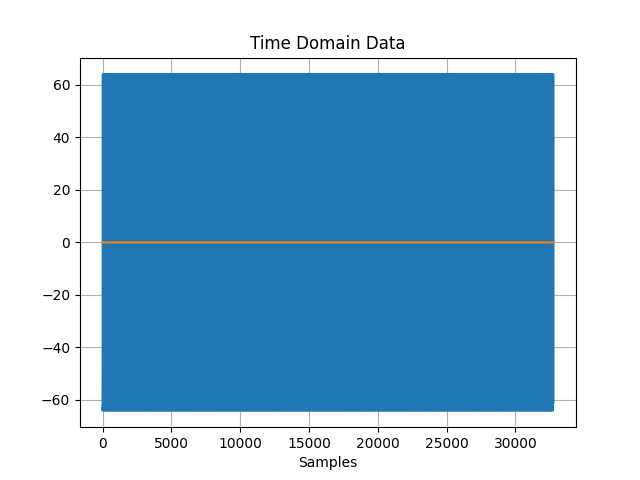

In [353]:
# adc sampling rate
adc_fs = 500
# dac sampling rate
dac_fs = 1000
# bandwidth
bw = 250
# fft points on the SNAP
fft_points = 2048
# check the single bin
# if it's 0, the signal will show up in all bins
single_bin=100
# fixed parameters in FPGA design
bytes_per_axis = 8
bytes_per_sample = 2
# dac FFT length
dac_fft_len = 32768
print('dac_ifft_len', dac_fft_len)

# generate the data for the DAC with DAC sampling rate=1000
cfil = CreateTestFilter(dac_fft_len, fft_points, bw = bw/dac_fs*2)
d_time = DacDataGen(dac_fft_len, cfil, single_bin=single_bin*dac_fft_len//fft_points//(dac_fs//adc_fs), scale = 2**20)
Scope([d_time.real, d_time.imag])
nbuf = ToBytes(d_time.real)
# spec = SpectraAnalyzer(d_time.real, fs=dac_fs)

zeros = np.zeros(2**13*2, dtype=np.short)
zeros_bytes = struct.pack('>%dh'%len(zeros), *zeros)
rfsoc.write('wf_bram_0', zeros_bytes)
rfsoc.write('wf_bram_0', nbuf)
rfsoc.write_int('wf_en', 1)
samples_per_cyc = dac_fft_len
max_addr = int(samples_per_cyc*bytes_per_sample/bytes_per_axis - 3)
print('max_addr', max_addr)
rfsoc.write_int('addr_max', max_addr)

In [301]:
len(nbuf)

8192

In [324]:
d = ADCSampling(d_time.real,  adc_fs=adc_fs, dac_fs=dac_fs)

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

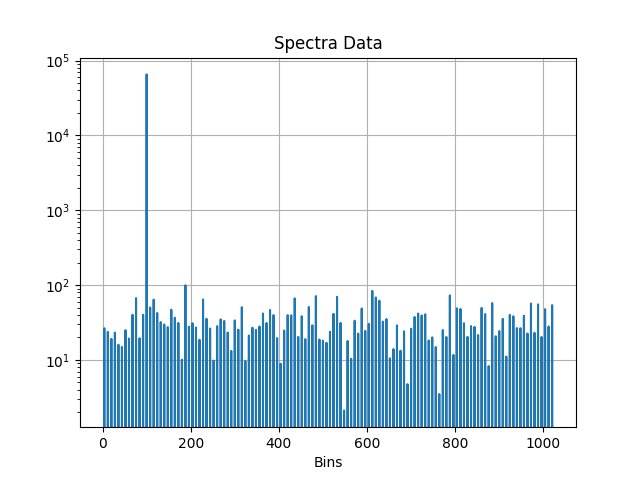

In [325]:
SpectraAnalyzer(d[:fft_points], fs=adc_fs, show_bin=True)